<a href="https://colab.research.google.com/github/hgene0929/deep_learning/blob/main/test_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib

# models 폴더가 존재하지 않는다면 git clone으로 models repository를 다운로드 받습니다.
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone https://github.com/tensorflow/models
  %cd models
  #!git reset --hard d7ce106b8ea449cc629569ca43a95e55a18807fa  # 안정적인 version의 commit으로 reset
  %cd ..

In [ ]:
# TensorFlow Object Detection API를 설치합니다.
# Reference : https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md 
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install --upgrade pip
python -m pip install --use-feature=2020-resolver .

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [5]:
# path 경로에서 이미지를 읽어서 numpy array 형태로 반환합니다.
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [6]:
# faster r-cnn 모델을 불러옵니다. 다른 모델 사용할 경우, 위의 git 파일에서 사용할 모델의 링크 주소를 복사하여 전체 이름을 넣으면 된다.
model_name = 'faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8'

In [ ]:
# ms coco dataset에 학습된 fasterrcnn의 checkpoint 파일을 다운로드하고 압축을 풉니다.
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz
!tar -xf faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz
# 해당 checkpoint 파일을 models/research/object_detection/test_data/ 경로로 옮깁니다.
!mv faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [8]:
# config 파일과 checkpoint 파일의 경로를 설정합니다.
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/', model_name + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# config파일을 이용해서 모델 인스턴스를 생성합니다.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# checkpoint 파일로부터 파라미터를 복원합니다.
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

# model의 예측 결과를 받아옵니다.
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [9]:
# ms coco 레이블들을 읽어옵니다.
LABEL_MAP_PATH = 'models/research/object_detection/data/mscoco_label_map.pbtxt'

label_map_path = LABEL_MAP_PATH
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [ ]:
categories

In [11]:
!unzip test_images.zip

Archive:  test_images.zip
  inflating: test_images/image1.jpg  
  inflating: test_images/image10.jpg  
  inflating: test_images/image11.jpg  
  inflating: test_images/image12.jpg  
  inflating: test_images/image13.jpg  
  inflating: test_images/image14.jpg  
  inflating: test_images/image15.jpg  
  inflating: test_images/image16.jpg  
  inflating: test_images/image17.jpg  
  inflating: test_images/image18.jpg  
  inflating: test_images/image19.jpg  
  inflating: test_images/image2.jpg  
  inflating: test_images/image20.jpg  
  inflating: test_images/image21.jpg  
  inflating: test_images/image22.jpg  
  inflating: test_images/image3.jpg  
  inflating: test_images/image4.jpg  
  inflating: test_images/image5.jpg  
  inflating: test_images/image6.jpg  
  inflating: test_images/image7.jpg  
  inflating: test_images/image8.jpg  
  inflating: test_images/image9.jpg  


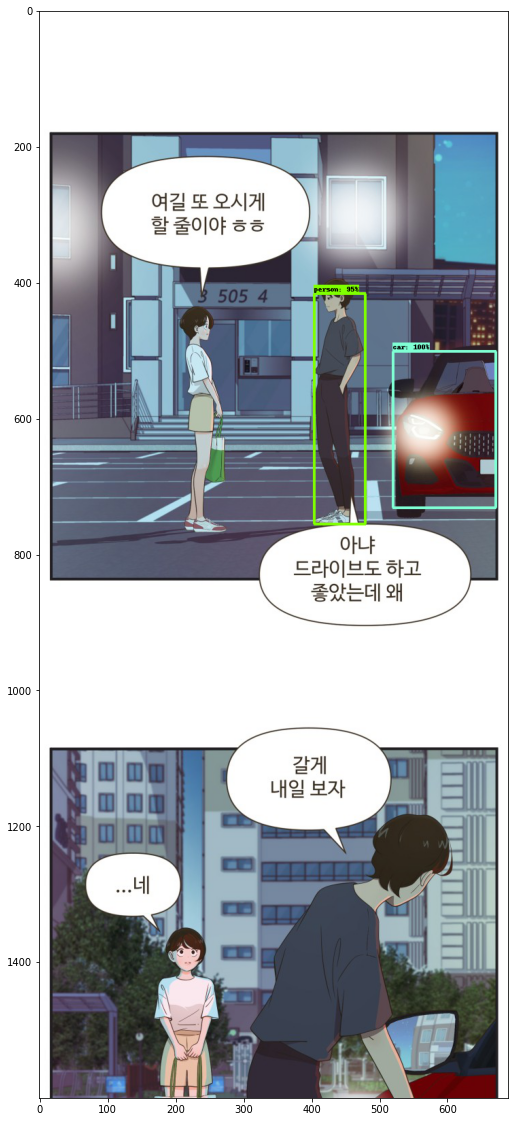

In [13]:
# 이미지 파일 경로에서 테스트 이미지를 np.array 형태로 읽어옵니다.
image_dir = 'test_images/'
image_path = os.path.join(image_dir, 'image1.jpg')
image_np = load_image_into_numpy_array(image_path)

# 이미지에 대한 예측을 수행합니다.
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# image_np_with_detections np.array에 시각화 결과를 반환합니다.
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.70,
      agnostic_mode=False
      )

plt.figure(figsize=(20,20))
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
category_index

In [15]:
import collections
import six
from six.moves import range
from six.moves import zip

STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]


def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
  """Adds a bounding box to an image (numpy array).
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a numpy array with shape [height, width, 3].
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Each string in display_str_list is displayed on a separate line above the
  bounding box in black text on a rectangle filled with the input 'color'.
  If the top of the bounding box extends to the edge of the image, the strings
  are displayed below the bounding box.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  if thickness > 0:
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin

In [16]:
# detection_name_list에 대응되는 label만 시각화
def visualize_boxes_and_labels_on_image_array_only_filtered_classes(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    keypoint_scores=None,
    keypoint_edges=None,
    track_ids=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    mask_alpha=.4,
    groundtruth_box_visualization_color='black',
    skip_boxes=False,
    skip_scores=False,
    skip_labels=False,
    skip_track_ids=False,
    detection_name_list = []
    ):
  """Overlay labeled boxes on an image with formatted scores and label names.
  This function groups boxes that correspond to the same location
  and creates a display string for each detection and overlays these
  on the image. Note that this function modifies the image in place, and returns
  that same image.
  Args:
    image: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    instance_masks: a uint8 numpy array of shape [N, image_height, image_width],
      can be None.
    instance_boundaries: a numpy array of shape [N, image_height, image_width]
      with values ranging between 0 and 1, can be None.
    keypoints: a numpy array of shape [N, num_keypoints, 2], can
      be None.
    keypoint_scores: a numpy array of shape [N, num_keypoints], can be None.
    keypoint_edges: A list of tuples with keypoint indices that specify which
      keypoints should be connected by an edge, e.g. [(0, 1), (2, 4)] draws
      edges from keypoint 0 to 1 and from keypoint 2 to 4.
    track_ids: a numpy array of shape [N] with unique track ids. If provided,
      color-coding of boxes will be determined by these ids, and not the class
      indices.
    use_normalized_coordinates: whether boxes is to be interpreted as
      normalized coordinates or not.
    max_boxes_to_draw: maximum number of boxes to visualize.  If None, draw
      all boxes.
    min_score_thresh: minimum score threshold for a box or keypoint to be
      visualized.
    agnostic_mode: boolean (default: False) controlling whether to evaluate in
      class-agnostic mode or not.  This mode will display scores but ignore
      classes.
    line_thickness: integer (default: 4) controlling line width of the boxes.
    mask_alpha: transparency value between 0 and 1 (default: 0.4).
    groundtruth_box_visualization_color: box color for visualizing groundtruth
      boxes
    skip_boxes: whether to skip the drawing of bounding boxes.
    skip_scores: whether to skip score when drawing a single detection
    skip_labels: whether to skip label when drawing a single detection
    skip_track_ids: whether to skip track id when drawing a single detection
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3) with overlaid boxes.
  """
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_instance_boundaries_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  box_to_keypoint_scores_map = collections.defaultdict(list)
  box_to_track_ids_map = {}
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(boxes.shape[0]):
    if max_boxes_to_draw == len(box_to_color_map):
      break
    # detection_name_list에 대응되는 label만 시각화
    if (scores is None or scores[i] > min_score_thresh) and category_index[classes[i]]['name'] in detection_name_list:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if keypoint_scores is not None:
        box_to_keypoint_scores_map[box].extend(keypoint_scores[i])
      if track_ids is not None:
        box_to_track_ids_map[box] = track_ids[i]
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in six.viewkeys(category_index):
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(round(100*scores[i]))
          else:
            display_str = '{}: {}%'.format(display_str, round(100*scores[i]))
        if not skip_track_ids and track_ids is not None:
          if not display_str:
            display_str = 'ID {}'.format(track_ids[i])
          else:
            display_str = '{}: ID {}'.format(display_str, track_ids[i])
        box_to_display_str_map[box].append(display_str)
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        elif track_ids is not None:
          prime_multipler = _get_multiplier_for_color_randomness()
          box_to_color_map[box] = STANDARD_COLORS[
              (prime_multipler * track_ids[i]) % len(STANDARD_COLORS)]
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Draw all boxes onto image.
  for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box
    draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=0 if skip_boxes else line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)

  return image

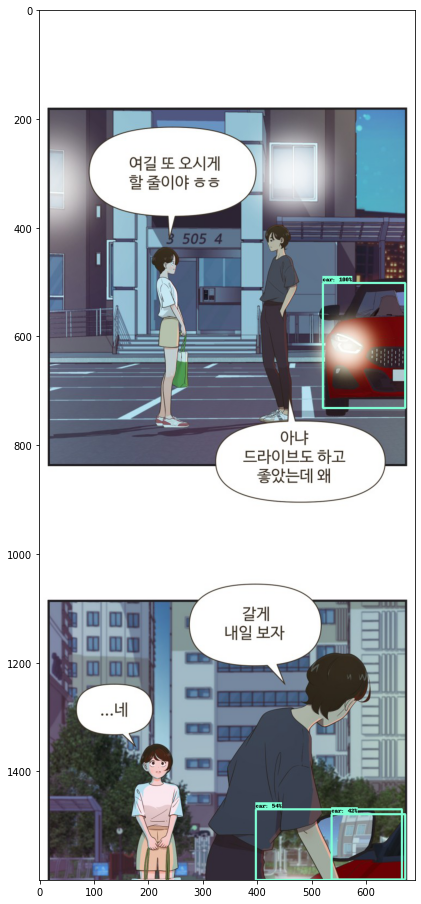

In [17]:
image_dir = 'test_images/'
image_path = os.path.join(image_dir, 'image1.jpg')
image_np = load_image_into_numpy_array(image_path)

# 이미지에 대한 예측을 수행합니다.
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# image_np_with_detections np.array에 시각화 결과를 반환합니다.
# visualize_boxes_and_labels_on_image_array_only_filtered_classes 함수를 이용해서 'person' class만 검출합니다.
visualize_boxes_and_labels_on_image_array_only_filtered_classes(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      detection_name_list = ['car']
      )

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
import glob
test_image_file_list = glob.glob('test_images/*.jpg')
test_image_file_list

In [19]:
import imageio

def predict_and_save_result(image_path,
                            output_image_path,
                            confidence_threshold=0.3,
                            detection_name_list=['car','handbag']):
  image_np = load_image_into_numpy_array(image_path)

  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  visualize_boxes_and_labels_on_image_array_only_filtered_classes(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=confidence_threshold,
        agnostic_mode=False,
        detection_name_list = detection_name_list
        )

  # prediction 결과를 파일로 저장
  imageio.imwrite(output_image_path, image_np_with_detections) 

In [20]:
test_image_file_list[0].split('/')[-1]

'image2.jpg'

In [21]:
!mkdir test_image_predict_result

In [22]:
from tqdm import tqdm

output_folder = 'test_image_predict_result'
for test_image_path in tqdm(test_image_file_list):
  output_image_path = os.path.join(output_folder, test_image_path.split('/')[-1])
  # person을 검출하고 검출내역을 저장합니다.
  predict_and_save_result(test_image_path,
                          output_image_path,
                          confidence_threshold=0.3,
                          detection_name_list=['car','handbag']
                          )

100%|██████████| 22/22 [05:44<00:00, 15.65s/it]


In [23]:
!zip -r /content/test_image_predict_result.zip /content/test_image_predict_result

  adding: content/test_image_predict_result/ (stored 0%)
  adding: content/test_image_predict_result/image2.jpg (deflated 14%)
  adding: content/test_image_predict_result/image13.jpg (deflated 13%)
  adding: content/test_image_predict_result/image4.jpg (deflated 18%)
  adding: content/test_image_predict_result/image21.jpg (deflated 8%)
  adding: content/test_image_predict_result/image8.jpg (deflated 19%)
  adding: content/test_image_predict_result/image7.jpg (deflated 15%)
  adding: content/test_image_predict_result/image5.jpg (deflated 13%)
  adding: content/test_image_predict_result/image9.jpg (deflated 17%)
  adding: content/test_image_predict_result/image12.jpg (deflated 15%)
  adding: content/test_image_predict_result/image19.jpg (deflated 11%)
  adding: content/test_image_predict_result/image17.jpg (deflated 10%)
  adding: content/test_image_predict_result/image22.jpg (deflated 6%)
  adding: content/test_image_predict_result/image15.jpg (deflated 11%)
  adding: content/test_image

In [24]:
from google.colab import files
files.download("/content/test_image_predict_result.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>